# Embedding Model 만들기

In [3]:
#Dependencies
import pandas as pd
import numpy as np
import itertools

import logging, os

logging.disable(logging.WARNING)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

import tensorflow as tf

import matplotlib.pyplot as plt
import plotly.express as px

import time
import tqdm


ROOT_DIR = os.getcwd()
DATA_DIR = os.path.join(ROOT_DIR, 'ml-1m/')
STATE_SIZE = 10

In [6]:
#Loading datasets
ratings_list = [i.strip().split("::") for i in open(os.path.join(DATA_DIR,'ratings.dat'), 'r').readlines()]
users_list = [i.strip().split("::") for i in open(os.path.join(DATA_DIR,'users.dat'), 'r').readlines()]
movies_list = [i.strip().split("::") for i in open(os.path.join(DATA_DIR,'movies.dat'),encoding='latin-1').readlines()]
ratings_df = pd.DataFrame(ratings_list, columns = ['UserID', 'MovieID', 'Rating', 'Timestamp'])
ratings_df = ratings_df.astype({
    'UserID': np.uint32,
    'MovieID': np.uint32,
    'Rating': np.uint8,
    'Timestamp': np.uint32
})
movies_df = pd.DataFrame(movies_list, columns = ['MovieID', 'Title', 'Genres'])
movies_df['MovieID'] = movies_df['MovieID'].apply(pd.to_numeric)
users_df = pd.DataFrame(users_list, columns=['UserID','Gender','Age','Occupation','Zip-code'])

In [ ]:
movies_id_to_movies = {movie[0]: movie[1:] for movie in movies_list}

In [9]:
len(movies_list)

3883

In [10]:
movies_df.head(5)

,MovieID,Title,Genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [11]:
ratings_df.head(5)

,UserID,MovieID,Rating,Timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [12]:
genres = ['Action',
        'Adventure',
        'Animation',
        "Children's",
        'Comedy',
        'Crime',
        'Documentary',
        'Drama',
        'Fantasy',
        'Film-Noir',
        'Horror',
        'Musical',
        'Mystery',
        'Romance',
        'Sci-Fi',
        'Thriller',
        'War',
        'Western']

## Dataframe

In [ ]:

movies_genres_df = movies_df[['MovieID', 'Genres']]

In [14]:
movies_genres_df.head(5)

,MovieID,Genres
0,1,Animation|Children's|Comedy
1,2,Adventure|Children's|Fantasy
2,3,Comedy|Romance
3,4,Comedy|Drama
4,5,Comedy


In [ ]:
# Genres
def _split_and_index(string):
    string = string.split('|')
    for i, s in enumerate(string):
        string[i] = genres.index(s)
    return string

movies_genres_df['Genres'] = movies_genres_df['Genres'].map(lambda x : _split_and_index(x))

C:\Users\garvi\AppData\Local\Temp\ipykernel_24480\3400017854.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies_genres_df['Genres'] = movies_genres_df['Genres'].map(lambda x : _split_and_index(x))


In [16]:
movies_genres_df.head(5)

,MovieID,Genres
0,1,"[2, 3, 4]"
1,2,"[1, 3, 8]"
2,3,"[4, 13]"
3,4,"[4, 7]"
4,5,[4]


In [ ]:
movies_genres_df.isnull().sum()

MovieID    0
Genres     0
dtype: int64

In [ ]:
len(movies_genres_df['MovieID'])

3883

In [19]:
movies_genres_df['MovieID'].nunique()

3883

In [ ]:
# Rating DataFrame
user_movie_rating_df = ratings_df[['UserID','MovieID','Rating']]

In [21]:
user_movie_rating_df.head(5)

,UserID,MovieID,Rating
0,1,1193,5
1,1,661,3
2,1,914,3
3,1,3408,4
4,1,2355,5


In [ ]:
user_movie_rating_df.isnull().sum()

UserID     0
MovieID    0
Rating     0
dtype: int64

In [23]:
user_movie_rating_df['UserID'].nunique()

6040

In [24]:
user_movie_rating_df['MovieID'].nunique()

3706

##  Case1. 

In [25]:
from tensorflow.keras.layers import InputLayer, Embedding, Dot, Reshape, Dense
from tensorflow.keras.models import Model

### Movie Genre Embedding  

In [ ]:
    class MovieGenreEmbedding(tf.keras.Model):
        def __init__(self, len_movies, len_genres, embedding_size):
            super(MovieGenreEmbedding, self).__init__()
            self.m_g_input = InputLayer(name='input_layer', input_shape=(2,))
            # embedding
            self.m_embedding = Embedding(name='movie_embedding', input_dim=len_movies, output_dim=embedding_size)
            self.g_embedding = Embedding(name='genre_embedding', input_dim=len_genres, output_dim=embedding_size)
            # dot product
            self.m_g_merge = Dot(name='movie_genre_dot', normalize=True, axes=1)
            # output
            self.m_g_fc = Dense(1, activation='sigmoid')
            
        def call(self, x):

            movie_input, genre_input = x
            memb = self.m_embedding(movie_input)
            gemb = self.g_embedding(genre_input)
            m_g = self.m_g_merge([memb, gemb])
            # x = self.m_g_input(x)
            # memb = self.m_embedding(x[0])
            # gemb = self.g_embedding(x[1])
            # m_g = self.m_g_merge([memb, gemb])
    #         m_g = self.reshape(m_g)
            return self.m_g_fc(m_g)

### User Embedding

In [ ]:
class UserMovieEmbedding(tf.keras.Model):
    def __init__(self, len_users, embedding_size):
        super(UserMovieEmbedding, self).__init__()
        self.m_u_input = InputLayer(name='input_layer', input_shape=(2,))
        # embedding
        self.u_embedding = Embedding(name='user_embedding', input_dim=len_users, output_dim=embedding_size)
        # dot product
        self.m_u_merge = Dot(name='movie_user_dot', normalize=False, axes=1)
        # output
        self.m_u_fc = Dense(1, activation='sigmoid')
        
    def call(self, x):
        user_input, movie_vector = x
        uemb = self.u_embedding(user_input)
        m_u = self.m_u_merge([movie_vector, uemb])
        return self.m_u_fc(m_u)
        # x = self.m_u_input(x)
        # uemb = self.u_embedding(x[0])
        # m_u = self.m_u_merge([x[1], uemb])
        # return self.m_u_fc(m_u)

## Data generator

### Movie Genre batch generator

In [ ]:
# movie genre data genration
movies_genres_df.head()

,MovieID,Genres
0,1,"[2, 3, 4]"
1,2,"[1, 3, 8]"
2,3,"[4, 13]"
3,4,"[4, 7]"
4,5,[4]


In [29]:
movies_genres_dict = {m : g for m, g in zip(movies_genres_df["MovieID"],movies_genres_df["Genres"])}
movies_genres_dict[1]

[2, 3, 4]

In [48]:
positive_m_g_pairs = []
negative_m_g_pairs = []
for movie in movies_genres_df["MovieID"]:
    for i in range(len(genres)):
        if i in movies_genres_dict[movie]:
            positive_m_g_pairs.append((movie, i, 1))
        else:
            negative_m_g_pairs.append((movie, i, 0))

In [50]:
def generate_movie_genre_batch(positive_pairs, negative_pairs, batch_size, negative_ratio=0.5):
    
    batch = np.zeros((batch_size, 3))
    num_of_positive = batch_size-int(batch_size*negative_ratio)
    
    while True:
        idx = np.random.choice(len(positive_pairs), num_of_positive)
        positive_data = np.array(positive_pairs)[idx]
        for i, data in enumerate(positive_data):
            batch[i] = data
        
        idx = np.random.choice(len(negative_pairs), int(batch_size*negative_ratio))
        negative_data = np.array(negative_pairs)[idx]
        for i, data in enumerate(negative_data):
            batch[num_of_positive+i] = data
        
        np.random.shuffle(batch)
        yield batch[:,0], batch[:,1], batch[:,2]

In [ ]:
# user movie data generator
user_movie_rating_df = user_movie_rating_df.apply(np.int32)
user_movie_rating_df.head()

,UserID,MovieID,Rating
0,1,1193,5
1,1,661,3
2,1,914,3
3,1,3408,4
4,1,2355,5


### User batch generator

In [52]:
modified_user_movie_rating_df = user_movie_rating_df.apply(np.int32)
index_names = modified_user_movie_rating_df[modified_user_movie_rating_df['Rating']<4].index
modified_user_movie_rating_df = modified_user_movie_rating_df.drop(index_names)
modified_user_movie_rating_df = modified_user_movie_rating_df.drop('Rating', axis=1)
u_m_pairs = modified_user_movie_rating_df.to_numpy()
u_m_pairs[:5]

array([[   1, 1193],
       [   1, 3408],
       [   1, 2355],
       [   1, 1287],
       [   1, 2804]], dtype=int32)

In [69]:
positive_user_movie_dict = {u : [] for u in range(1, max(modified_user_movie_rating_df['UserID'])+1)}
for data in modified_user_movie_rating_df.iterrows():
    positive_user_movie_dict[data[1][0]].append(data[1][1])
positive_user_movie_dict[1]

C:\Users\garvi\AppData\Local\Temp\ipykernel_24480\4189759124.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  positive_user_movie_dict[data[1][0]].append(data[1][1])


[np.int32(1193),
 np.int32(3408),
 np.int32(2355),
 np.int32(1287),
 np.int32(2804),
 np.int32(594),
 np.int32(919),
 np.int32(595),
 np.int32(938),
 np.int32(2398),
 np.int32(2918),
 np.int32(1035),
 np.int32(2791),
 np.int32(2018),
 np.int32(3105),
 np.int32(2797),
 np.int32(1270),
 np.int32(527),
 np.int32(48),
 np.int32(1097),
 np.int32(1721),
 np.int32(1545),
 np.int32(2294),
 np.int32(3186),
 np.int32(1566),
 np.int32(588),
 np.int32(1907),
 np.int32(783),
 np.int32(1836),
 np.int32(1022),
 np.int32(2762),
 np.int32(150),
 np.int32(1),
 np.int32(1961),
 np.int32(1962),
 np.int32(2692),
 np.int32(260),
 np.int32(1028),
 np.int32(1029),
 np.int32(1207),
 np.int32(2028),
 np.int32(531),
 np.int32(3114),
 np.int32(608),
 np.int32(1246)]

In [55]:
def generate_user_movie_batch(positive_pairs, batch_size, negative_ratio=0.5):
    batch = np.zeros((batch_size, 3))
    positive_batch_size = batch_size - int(batch_size*negative_ratio)
    max_user_id = max(modified_user_movie_rating_df['UserID'])+1
    max_movie_id = max(modified_user_movie_rating_df['MovieID'])+1
    
    while True:
        idx = np.random.choice(len(positive_pairs), positive_batch_size)
        data = positive_pairs[idx]
        for i, d in enumerate(data):
            batch[i] = (d[0], d[1], 1)
        
        while i+1 < batch_size:
            u = np.random.randint(1, max_user_id)
            m = np.random.randint(1, max_movie_id)
            if m not in positive_user_movie_dict[u]:
                i += 1
                batch[i] = (u, m, 0)
        
        np.random.shuffle(batch)
        yield batch[:,0], batch[:,1], batch[:,2]

In [56]:
LEN_MOVIES = max(movies_genres_df["MovieID"])+1
LEN_GENRES = len(genres)+1
LEN_USERS = max(user_movie_rating_df['UserID'])+1
EMBEDDING_SIZE = 100

MAX_EPOCH = 100
MOVIE_BATCH_SIZE = 128
MOVIE_STEP_PER_EPOCH = len(positive_m_g_pairs)//MOVIE_BATCH_SIZE

### Movie Genre Embedding

In [57]:
m_g_model = MovieGenreEmbedding(LEN_MOVIES, LEN_GENRES, EMBEDDING_SIZE)

c:\Users\garvi\anaconda3\envs\DRR\lib\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [58]:
m_g_model([np.zeros((1)),np.zeros((1))])
m_g_model.summary()

Model: "movie_genre_embedding_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ movie_embedding (Embedding)     │ (1, 100)               │       395,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ genre_embedding (Embedding)     │ (1, 100)               │         1,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ movie_genre_dot (Dot)           │ (1, 1)                 │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (1, 1)                 │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 397,202 (1.52 MB)

 Trainable params: 397,202 (1.52 MB)

 Non-trainable params: 0 (0.00 B)

In [59]:
# optimizer
optimizer = tf.keras.optimizers.Adam()
# loss
bce = tf.keras.losses.BinaryCrossentropy()

In [61]:
m_g_train_loss = tf.keras.metrics.Mean(name='train_loss')
m_g_train_accuracy = tf.keras.metrics.BinaryAccuracy(name='train_accuracy')

@tf.function
def m_g_train_step(m_g_inputs, labels):
    with tf.GradientTape() as tape:
        # training=True is only needed if there are layers with different
        # behavior during training versus inference (e.g. Dropout).
        predictions = m_g_model(m_g_inputs, training=True)
        loss = bce(labels, predictions)
    gradients = tape.gradient(loss, m_g_model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, m_g_model.trainable_variables))

    m_g_train_loss(loss)
    m_g_train_accuracy(labels, predictions)

In [62]:
# for log
m_g_losses = []

for epoch in range(MAX_EPOCH):
    
    m_g_generator = generate_movie_genre_batch(positive_m_g_pairs, negative_m_g_pairs, MOVIE_BATCH_SIZE, negative_ratio=0.5)
    
    for step in range(MOVIE_STEP_PER_EPOCH):
        # embedding layer update
        m_batch, g_batch, m_g_label_batch = next(m_g_generator)
        m_g_train_step([m_batch, g_batch], m_g_label_batch)
        
        print(f'{epoch} epoch, {step} steps, Loss: {m_g_train_loss.result():0.4f}, Accuracy: {m_g_train_accuracy.result() * 100:0.1f}', end='\r')

    m_g_losses.append(m_g_train_loss.result())

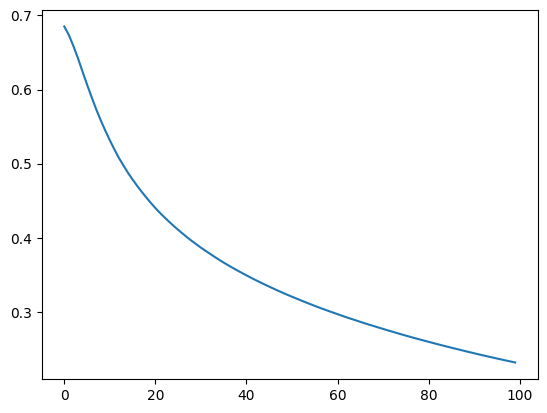

In [63]:
plt.plot(m_g_losses)

In [65]:
m_g_model.save_weights('./save_weights/m_g_model_weights.weights.h5')

### User Movie Embedding

In [123]:
MAX_EPOCH = 150
INIT_USER_BATCH_SIZE = 64
FINAL_USER_BATCH_SIZE = 1024

In [82]:
u_m_model = UserMovieEmbedding(LEN_USERS, EMBEDDING_SIZE)

In [83]:
u_m_model([np.zeros((1)),np.zeros((1,100))])
u_m_model.summary()

Model: "user_movie_embedding_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ user_embedding (Embedding)      │ (1, 100)               │       604,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ movie_user_dot (Dot)            │ (1, 1)                 │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (1, 1)                 │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 604,102 (2.30 MB)

 Trainable params: 604,102 (2.30 MB)

 Non-trainable params: 0 (0.00 B)

In [84]:
# optimizer
optimizer = tf.keras.optimizers.Adam()
# loss
bce = tf.keras.losses.BinaryCrossentropy()

In [85]:
u_m_train_loss = tf.keras.metrics.Mean(name='train_loss')
u_m_train_accuracy = tf.keras.metrics.BinaryAccuracy(name='train_accuracy')


@tf.function
def u_m_train_step(u_m_inputs, labels):
    with tf.GradientTape() as tape:
        # training=True is only needed if there are layers with different
        # behavior during training versus inference (e.g. Dropout).
        predictions = u_m_model(u_m_inputs, training=True)
        loss = bce(labels, predictions)
    gradients = tape.gradient(loss, u_m_model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, u_m_model.trainable_variables))

    u_m_train_loss(loss)
    u_m_train_accuracy(labels, predictions)

In [86]:
# for log
u_m_losses = []

for epoch in range(MAX_EPOCH):
    
    batch_size = INIT_USER_BATCH_SIZE * (epoch+1)
    if batch_size > FINAL_USER_BATCH_SIZE:
        batch_size = FINAL_USER_BATCH_SIZE
    u_m_generator = generate_user_movie_batch(u_m_pairs, batch_size)
    
    for step in range(len(user_movie_rating_df)//batch_size):
        # embedding layer update
        u_batch, m_batch, u_m_label_batch = next(u_m_generator)
        m_batch = m_g_model.get_layer('movie_embedding')(m_batch)
        u_m_train_step([u_batch, m_batch], u_m_label_batch)
        
        print(f'{epoch} epoch, Batch size : {batch_size}, {step} steps, Loss: {u_m_train_loss.result():0.4f}, Accuracy: {u_m_train_accuracy.result() * 100:0.1f}', end='\r')

    u_m_losses.append(u_m_train_loss.result())

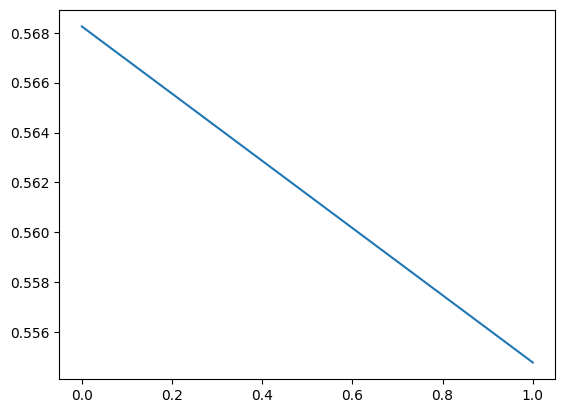

In [87]:
plt.plot(u_m_losses)

In [89]:
u_m_model.save_weights('./save_weights/u_m_model_weights.weights.h5')

In [95]:
movies_genres_df["MovieID"]

0          1
1          2
2          3
3          4
4          5
        ... 
3878    3948
3879    3949
3880    3950
3881    3951
3882    3952
Name: MovieID, Length: 3883, dtype: int64

In [ ]:
# embedded movie dataframe


def get_movie_embedding(movie_id):
    # Convert to tensor and add batch dimension (shape = (1,))
    movie_tensor = tf.convert_to_tensor([movie_id], dtype=tf.int32)
    return m_g_model.m_embedding(movie_tensor).numpy().flatten()

# Apply to the dataframe
embedded_movie = movies_genres_df['MovieID'].apply(get_movie_embedding)

# Convert to DataFrame
embedded_movie_df = pd.DataFrame(embedded_movie.tolist())

# embedded_movie = movies_genres_df['MovieID'].apply(m_g_model.get_layer('movie_embedding'))



columns = [x for x in range(100)]
embedded_movie_df = pd.DataFrame(columns = columns)

# `embedded_movie` is a Series of lists or arrays
embedded_movie_list = embedded_movie.tolist()  # convert to list of lists
embedded_movie_df = pd.DataFrame(embedded_movie_list, columns=[f'emb_{i}' for i in range(100)])
# for data in embedded_movie:
#     embedded_movie_df = embedded_movie_df.append(pd.Series(data), ignore_index=True)
embedded_movie_df.head()

,emb_0,emb_1,emb_2,emb_3,emb_4,emb_5,emb_6,emb_7,emb_8,emb_9,...,emb_90,emb_91,emb_92,emb_93,emb_94,emb_95,emb_96,emb_97,emb_98,emb_99
0,0.020110,0.052400,-0.090353,0.017690,-0.002917,0.122173,0.026016,-0.123935,0.024082,-0.062584,...,0.093692,-0.146537,-0.106533,0.035873,0.098473,0.115069,0.092159,-0.122883,0.026931,0.092291
1,-0.132138,0.068754,-0.079538,-0.046665,-0.133276,0.058724,-0.011351,-0.162281,-0.108460,-0.039942,...,0.005851,0.058718,0.085944,0.020009,0.049479,0.089485,0.051753,0.009366,0.001473,0.170293
2,0.054667,0.084603,-0.012657,0.122449,0.017365,0.070385,0.028130,-0.002023,0.017635,-0.036981,...,-0.045327,-0.097887,-0.027205,0.123751,-0.027582,-0.022903,-0.005502,-0.066164,0.002596,0.008637
3,0.115180,-0.030022,-0.007400,0.018689,-0.009018,0.123608,-0.084698,0.016933,-0.037662,-0.029657,...,-0.070280,-0.024823,-0.084495,0.005669,-0.030157,0.110382,-0.029425,0.021711,-0.003620,0.031993
4,0.032692,-0.019304,-0.023473,0.062720,0.086274,0.060505,-0.089668,-0.088053,0.066251,-0.085909,...,0.038462,-0.041057,-0.042600,0.101638,0.070561,0.073243,0.059412,-0.013625,0.096791,0.100657


In [ ]:
# PCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

movie_scaled = StandardScaler().fit_transform(embedded_movie_df)
pca = PCA(n_components=2)
pca.fit(movie_scaled)
movie_pca = pca.transform(movie_scaled)
pca_columns=[f'{n}' for n in range(2)]
movie_df_pca = pd.DataFrame(movie_pca,columns=pca_columns)
movie_df_pca = pd.concat([movie_df_pca, movies_df["Title"]], axis=1)
movie_df_pca = pd.concat([movie_df_pca, movies_df["Genres"]], axis=1)
movie_df_pca.head()

,0,1,Title,Genres
0,-7.334650,0.885292,Toy Story (1995),Animation|Children's|Comedy
1,-3.056353,-3.960323,Jumanji (1995),Adventure|Children's|Fantasy
2,-6.704491,2.834738,Grumpier Old Men (1995),Comedy|Romance
3,1.504007,7.176319,Waiting to Exhale (1995),Comedy|Drama
4,-6.410293,3.800877,Father of the Bride Part II (1995),Comedy


In [ ]:

fig = px.scatter(movie_df_pca, x='0', y='1', color='Genres')
fig.show()

In [ ]:
# T-SNE
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2).fit_transform(embedded_movie_df)
tsne_df = pd.DataFrame({'x': tsne[:, 0], 'y':tsne[:, 1]})
tsne_df = pd.concat([tsne_df, movies_df["Title"]], axis=1)
tsne_df = pd.concat([tsne_df, movies_df["Genres"]], axis=1)
tsne_df.head()

,x,y,Title,Genres
0,44.907871,1.489262,Toy Story (1995),Animation|Children's|Comedy
1,34.624397,-16.527613,Jumanji (1995),Adventure|Children's|Fantasy
2,4.699237,18.185938,Grumpier Old Men (1995),Comedy|Romance
3,-13.496420,49.367340,Waiting to Exhale (1995),Comedy|Drama
4,27.824667,31.600866,Father of the Bride Part II (1995),Comedy


In [ ]:

fig = px.scatter(tsne_df, x='x', y='y', color='Genres')
fig.show()

In [ ]:
embedding_layer = u_m_model.get_layer('user_embedding')
embedded_user_list = []

for uid in users_df['UserID']:
    tensor_input = tf.convert_to_tensor([int(uid)], dtype=tf.int32)
    embedding = embedding_layer(tensor_input)
    embedded_user_list.append(tf.squeeze(embedding).numpy())

embedded_user_df = pd.DataFrame(embedded_user_list, columns=[f'emb_{i}' for i in range(100)])




# # embedded user dataframe]
# embedded_user = users_df['UserID'].apply(np.int32).apply(u_m_model.get_layer('user_embedding'))
# columns = [x for x in range(100)]
# embedded_user_df = pd.DataFrame(columns = columns)
# for data in embedded_user:
#     embedded_user_df = embedded_user_df.append(pd.Series(data.numpy()), ignore_index=True)
# embedded_user_df.head()

In [108]:
users_df.head()

,UserID,Gender,Age,Occupation,Zip-code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


In [ ]:
# PCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

user_scaled = StandardScaler().fit_transform(embedded_user_df)
pca = PCA(n_components=2)
pca.fit(user_scaled)
user_pca = pca.transform(user_scaled)
pca_columns=[f'{n}' for n in range(2)]
user_df_pca = pd.DataFrame(user_pca,columns=pca_columns)
user_df_pca = pd.concat([user_df_pca, users_df["Gender"]], axis=1)
user_df_pca = pd.concat([user_df_pca, users_df["Age"]], axis=1)
user_df_pca = pd.concat([user_df_pca, users_df["Zip-code"]], axis=1)
user_df_pca.head()

,0,1,Gender,Age,Zip-code
0,3.691739,3.478288,F,1,48067
1,-2.218536,-0.498133,M,56,70072
2,0.626952,-0.618225,M,25,55117
3,7.271511,-5.213413,M,45,02460
4,-2.558027,1.686997,M,25,55455


In [ ]:

fig = px.scatter(user_df_pca, x='0', y='1', hover_data=user_df_pca)
fig.show()

In [ ]:
# T-SNE
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2).fit_transform(embedded_user_df)
tsne_df = pd.DataFrame({'x': tsne[:, 0], 'y':tsne[:, 1]})
tsne_df = pd.concat([tsne_df, users_df["Gender"]], axis=1)
tsne_df = pd.concat([tsne_df, users_df["Age"]], axis=1)
tsne_df = pd.concat([tsne_df, users_df["Zip-code"]], axis=1)
tsne_df.head()

,x,y,Gender,Age,Zip-code
0,51.883751,21.712009,F,1,48067
1,-14.433639,26.912439,M,56,70072
2,35.422729,-20.915955,M,25,55117
3,20.739639,-42.090347,M,45,02460
4,-24.987289,2.728148,M,25,55455


In [ ]:

fig = px.scatter(tsne_df, x='x', y='y', hover_data=tsne_df)
fig.show()

##  Case2.

In [113]:
LEN_MOVIES = max(movies_genres_df["MovieID"])+1
LEN_GENRES = len(genres)+1
LEN_USERS = max(user_movie_rating_df['UserID'])+1
EMBEDDING_SIZE = 100

In [117]:
class TestUserMovieEmbedding(tf.keras.Model):
    def __init__(self, len_users, len_movies, embedding_size):
        super(TestUserMovieEmbedding, self).__init__()
        self.m_u_input = InputLayer(name='input_layer', input_shape=(2,))
        # embedding
        self.u_embedding = Embedding(name='user_embedding', input_dim=len_users, output_dim=embedding_size)
        self.m_embedding = Embedding(name='movie_embedding', input_dim=len_movies, output_dim=embedding_size)
        # dot product
        self.m_u_merge = Dot(name='movie_user_dot', normalize=False, axes=1)
        # output
        self.m_u_fc = Dense(1, activation='sigmoid')
        
    def call(self, x):
        user_input, movie_vector = x
        # x = self.m_u_input(x)
        uemb = self.u_embedding(user_input)
        memb = self.m_embedding(movie_vector)
        m_u = self.m_u_merge([memb, uemb])
        return self.m_u_fc(m_u)

In [124]:
MAX_EPOCH = 150
INIT_USER_BATCH_SIZE = 64
FINAL_USER_BATCH_SIZE = 1024

In [119]:
test_model = TestUserMovieEmbedding(LEN_USERS, LEN_MOVIES, EMBEDDING_SIZE)

test_model([np.zeros((1)),np.zeros((1))])
test_model.summary()

c:\Users\garvi\anaconda3\envs\DRR\lib\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning:

Argument `input_shape` is deprecated. Use `shape` instead.



Model: "test_user_movie_embedding_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ user_embedding (Embedding)      │ (1, 100)               │       604,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ movie_embedding (Embedding)     │ (1, 100)               │       395,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ movie_user_dot (Dot)            │ (1, 1)                 │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (1, 1)                 │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 999,402 (3.81 MB)

 Trainable params: 999,402 (3.81 MB)

 Non-trainable params: 0 (0.00 B)

In [120]:
# optimizer
optimizer = tf.keras.optimizers.Adam()
# loss
bce = tf.keras.losses.BinaryCrossentropy()

In [121]:
test_train_loss = tf.keras.metrics.Mean(name='train_loss')
test_train_accuracy = tf.keras.metrics.BinaryAccuracy(name='train_accuracy')


@tf.function
def test_train_step(test_inputs, labels):
    with tf.GradientTape() as tape:
        # training=True is only needed if there are layers with different
        # behavior during training versus inference (e.g. Dropout).
        predictions = test_model(test_inputs, training=True)
        loss = bce(labels, predictions)
    gradients = tape.gradient(loss, test_model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, test_model.trainable_variables))

    test_train_loss(loss)
    test_train_accuracy(labels, predictions)

In [122]:
# for log
test_losses = []

for epoch in range(MAX_EPOCH):
    
    batch_size = INIT_USER_BATCH_SIZE * (epoch+1)
    if batch_size > FINAL_USER_BATCH_SIZE:
        batch_size = FINAL_USER_BATCH_SIZE
    test_generator = generate_user_movie_batch(u_m_pairs, batch_size)
    
    for step in range(len(user_movie_rating_df)//batch_size):
        # embedding layer update
        u_batch, m_batch, u_m_label_batch = next(test_generator)
        test_train_step([u_batch, m_batch], u_m_label_batch)
        
        print(f'{epoch} epoch, Batch size : {batch_size}, {step} steps, Loss: {test_train_loss.result():0.4f}, Accuracy: {test_train_accuracy.result() * 100:0.1f}', end='\r')

    test_losses.append(test_train_loss.result())

In [ ]:
# embedded movie dataframe 만들기
# embedded_movie = movies_genres_df['MovieID'].apply(test_model.get_layer('movie_embedding'))
# columns = [x for x in range(100)]
# embedded_movie_df = pd.DataFrame(columns = columns)
# for data in embedded_movie:
#     embedded_movie_df = embedded_movie_df.append(pd.Series(data), ignore_index=True)

# Get the embedding layer
embedding_layer = test_model.get_layer('movie_embedding')
# Convert movie IDs to tensors and pass through the embedding layer
embedded_movie = []
for movie_id in movies_genres_df['MovieID']:
    # Reshape and convert to tensor
    tensor_id = tf.convert_to_tensor([movie_id])
    embedding = embedding_layer(tensor_id).numpy().flatten()
    embedded_movie.append(embedding)
# Create DataFrame from the list
columns = list(range(len(embedded_movie[0])))
embedded_movie_df = pd.DataFrame(embedded_movie, columns=columns)


embedded_movie_df.head()

# PCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

movie_scaled = StandardScaler().fit_transform(embedded_movie_df)
pca = PCA(n_components=2)
pca.fit(movie_scaled)
movie_pca = pca.transform(movie_scaled)
pca_columns=[f'{n}' for n in range(2)]
movie_df_pca = pd.DataFrame(movie_pca,columns=pca_columns)
movie_df_pca = pd.concat([movie_df_pca, movies_df["Title"]], axis=1)
movie_df_pca = pd.concat([movie_df_pca, movies_df["Genres"]], axis=1)
movie_df_pca.head()

# Plot
fig = px.scatter(movie_df_pca, x='0', y='1', color='Genres')
fig.show()

In [ ]:
# T-SNE
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2).fit_transform(embedded_movie_df)
tsne_df = pd.DataFrame({'x': tsne[:, 0], 'y':tsne[:, 1]})
tsne_df = pd.concat([tsne_df, movies_df["Title"]], axis=1)
tsne_df = pd.concat([tsne_df, movies_df["Genres"]], axis=1)
tsne_df.head()

# 시각화
fig = px.scatter(tsne_df, x='x', y='y', color='Genres')
fig.show()

In [ ]:
# embedded user dataframe
# Get the user embedding layer
user_embedding_layer = test_model.get_layer('user_embedding')

# Accumulate embedded vectors in a list
embedded_user = []
for user_id in users_df['UserID']:
    tensor_id = tf.convert_to_tensor([int(user_id)])  # ensure it's an int32 tensor
    embedding = user_embedding_layer(tensor_id).numpy().flatten()
    embedded_user.append(embedding)

# Create DataFrame from the list
columns = list(range(len(embedded_user[0])))
embedded_user_df = pd.DataFrame(embedded_user, columns=columns)

# Preview the result
embedded_user_df.head()



# embedded_user = users_df['UserID'].apply(np.int32).apply(test_model.get_layer('user_embedding'))
# columns = [x for x in range(100)]
# embedded_user_df = pd.DataFrame(columns = columns)
# for data in embedded_user:
#     embedded_user_df = embedded_user_df.append(pd.Series(data.numpy()), ignore_index=True)
# embedded_user_df.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,-0.029076,0.296393,0.673770,0.653242,-0.560900,-0.194178,0.713966,0.302770,0.321233,0.002717,...,-0.564133,0.383314,0.038356,0.325144,-0.831880,0.367278,-0.141959,1.219217,0.073385,0.898022
1,-0.206981,-0.376826,0.171619,0.576214,-0.907539,-1.411737,0.076851,1.233785,0.412978,0.568294,...,0.567978,0.515821,-0.243810,-0.710635,-0.055298,1.001556,-0.569391,0.400583,-0.105429,-0.138578
2,1.138021,-0.854215,1.180198,-1.015202,-0.846621,-0.838018,0.387200,1.575112,-1.023039,0.432058,...,0.249453,1.454531,0.148606,-0.126894,-0.367690,0.112602,1.452677,0.919660,0.110904,0.239499
3,0.592025,-0.682367,1.234748,-0.200231,-0.434546,-0.279922,-0.266418,0.589811,0.235667,-0.428216,...,0.050261,-0.255446,0.758308,-0.477864,-1.220074,-0.834183,-0.068751,0.657015,-0.400730,-0.571371
4,-1.421586,-0.376615,1.277206,-0.094879,-0.161964,-1.217240,-0.152178,0.309310,0.129315,-0.599067,...,-0.760096,0.973175,0.230430,0.757405,-0.247504,-0.693314,-0.741689,0.592925,-1.090235,0.999158


In [ ]:
# T-SNE
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2).fit_transform(embedded_user_df)
tsne_df = pd.DataFrame({'x': tsne[:, 0], 'y':tsne[:, 1]})
tsne_df = pd.concat([tsne_df, users_df["Gender"]], axis=1)
tsne_df = pd.concat([tsne_df, users_df["Age"]], axis=1)
tsne_df = pd.concat([tsne_df, users_df["Zip-code"]], axis=1)
tsne_df.head()

,x,y,Gender,Age,Zip-code
0,-7.844846,-21.009899,F,1,48067
1,12.523875,36.460083,M,56,70072
2,-7.246458,14.582832,M,25,55117
3,-6.086277,37.003204,M,45,02460
4,27.290663,-6.694346,M,25,55455


In [ ]:

fig = px.scatter(tsne_df, x='x', y='y', color='Age', hover_data=tsne_df)
fig.show()

In [134]:
test_model.save_weights('./save_weights/user_movie_at_once.weights.h5')